#Environment Check

In [1]:
import gymnasium as gym
from twsbr_env.envs import TwsbrEnv  # Import environment
import time
from stable_baselines3.common.env_checker import check_env

env = gym.make("TwsbrEnv-v0",
                render_mode=None,
                action_type="continuous",
                )
check_env(env)
env.close()

#PID MODE

In [2]:
import gymnasium as gym
from twsbr_env.envs import TwsbrEnv

# Create the environment with specific parameters
env = gym.make(
    "TwsbrEnv-v0",
    render_mode="human",
    action_type="continuous"  # Action type
)

obs, info = env.reset()
done = False
truncated = False
acc_reward = 0  # Inisialisasi akumulasi reward

In [3]:
env.action_space

Box(-1.0, 1.0, (2,), float32)

In [9]:
action = env.action_space.sample()
obs, reward, done, truncated, info = env.step(action)

In [10]:
obs, reward, done, truncated, info

(array([ 1.8282731e-01, -4.3297533e-02,  1.6234828e-03, -1.7756574e-04,
         3.9000001e-02, -6.9400001e-01], dtype=float32),
 -0.6948284495546785,
 False,
 False,
 {'step_count': 2, 'target': array([ 0.39, -6.94,  0.  ])})

In [15]:
env.close()

In [1]:
# main.py
import gymnasium as gym
from twsbr_env.envs import TwsbrEnv
#from pid_controller import PIDController
#from utils import mps_to_radps
#from plot_results import plot_pid_results
import numpy as np

# Initialize the environment
env = gym.make(
    "TwsbrEnv-v0",
    render_mode="human",
    action_type="continuous"
)

# pid_controller.py
class PIDController:
    def __init__(self, kp, ki, kd, dt):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.dt = dt

        self.integral = 0.0
        self.prev_error = 0.0

    def compute(self, current_value, target_value):
        error = target_value - current_value
        self.integral += error * self.dt
        derivative = (error - self.prev_error) / self.dt
        self.prev_error = error

        output = (self.kp * error) + (self.ki * self.integral) + (self.kd * derivative)
        return output

# utils.py
import numpy as np

def mps_to_radps(mps):
    """Converts linear velocity (m/s) to angular velocity (rad/s) for a wheel radius of 4.5 cm."""
    return mps / 0.045  # Wheel radius = 4.5 cm

# plot_results.py
import matplotlib.pyplot as plt

def plot_pid_results(time_list, data_dict):
    """Plots PID results with given time and data."""
    plt.figure(figsize=(20, 20))

    for idx, (title, pid_data) in enumerate(data_dict.items()):
        target = pid_data['target']
        current = pid_data['current']
        error = pid_data['error']
        
        plt.subplot(len(data_dict), 1, idx + 1)
        plt.plot(time_list, target, label=f"{title} Target", color='r')
        plt.plot(time_list, current, label=f"{title} Current", color='b')
        plt.plot(time_list, error, label=f"{title} Error", color='y')
        plt.title(f"{title} PID")
        plt.xlabel("Time (s)")
        plt.ylabel("Target / Error")
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.show()
  

# PID Controllers
dt = 1.0 / 100.0
velocity_pid = PIDController(kp=0.01, ki=0.0, kd=0.0, dt=dt)
balance_pid = PIDController(kp=0.5, ki=0.0, kd=0.0, dt=dt)
steer_pid = PIDController(kp=0.1, ki=0.0, kd=0.0, dt=dt)

# Simulation settings
sim_duration = 10
steps = int(sim_duration / dt)
time_list = []

# Data storage
data_dict = {
    'velocity': {'target': [], 'current': [], 'error': []},
    'balance': {'target': [], 'current': [], 'error': []},
    'steer': {'target': [], 'current': [], 'error': []}
}

obs, info = env.reset()
acc_reward = 0

for step in range(steps):
    current_time = step * dt
    time_list.append(current_time)

    # Velocity PID
    velocity_target = mps_to_radps(0.01)
    current_velocity = mps_to_radps(obs[5])
    velocity_output = velocity_pid.compute(current_velocity, velocity_target)

    # Balance PID
    balance_target = 0.0 
    current_angle = obs[6]
    balance_output = -balance_pid.compute(current_angle, balance_target)
    balance_output = np.clip(balance_output, -250, 250)

    # Steer PID
    steer_target = 0.0
    current_line_position = obs[7]
    steer_output = steer_pid.compute(current_line_position, steer_target)

    # Store data
    for key, (target_val, current_val, error_val) in zip(
    data_dict.keys(),
    [(velocity_target, current_velocity, velocity_target - current_velocity),
     (balance_target, current_angle, balance_target - current_angle),
     (steer_target, current_line_position, steer_target - current_line_position)]
    ):
        data_dict[key]['target'].append(target_val)
        data_dict[key]['current'].append(current_val)
        data_dict[key]['error'].append(error_val)

    # Combine outputs for wheel commands
    left_wheel_command = balance_output - steer_output
    right_wheel_command = balance_output + steer_output
    left_wheel_command = 0#np.clip(left_wheel_command, -250, 250)
    right_wheel_command = 0#np.clip(right_wheel_command, -250, 250)

    # Take action
    action = np.array([left_wheel_command, right_wheel_command])
    obs, reward, done, truncated, info = env.step(action)
    acc_reward += reward

    if done or truncated:
        obs, info = env.reset()

    env.render()

print(f"REWARD: {acc_reward}")
env.close()

# Plot results
plot_pid_results(time_list, data_dict)


error: Cannot load URDF file.

In [ ]:
# main.py
import gymnasium as gym
from twsbr_env.envs import TwsbrEnv
#from pid_controller import PIDController
#from utils import mps_to_radps
#from plot_results import plot_pid_results
import numpy as np

# Initialize the environment
env = gym.make(
    "TwsbrEnv-v0",
    render_mode="human",
    action_type="continuous"
)

# pid_controller.py
class PIDController:
    def __init__(self, kp, ki, kd, dt):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.dt = dt

        self.integral = 0.0
        self.prev_error = 0.0

    def compute(self, current_value, target_value):
        error = target_value - current_value
        self.integral += error * self.dt
        derivative = (error - self.prev_error) / self.dt
        self.prev_error = error

        output = (self.kp * error) + (self.ki * self.integral) + (self.kd * derivative)
        return output

# utils.py
import numpy as np

def mps_to_radps(mps):
    """Converts linear velocity (m/s) to angular velocity (rad/s) for a wheel radius of 4.5 cm."""
    return mps / 0.045  # Wheel radius = 4.5 cm

# plot_results.py
import matplotlib.pyplot as plt

def plot_pid_results(time_list, data_dict, additional_data=None):
    """Plots PID results and actions separately."""
    # Plot PID outputs
    plt.figure(figsize=(20, 15))
    for idx, (title, pid_data) in enumerate(data_dict.items()):
        target = pid_data['target']
        current = pid_data['current']
        error = pid_data['error']
        
        plt.subplot(len(data_dict), 1, idx + 1)
        plt.plot(time_list, target, label=f"{title} Target", color='r')
        plt.plot(time_list, current, label=f"{title} Current", color='b')
        plt.plot(time_list, error, label=f"{title} Error", color='y')
        plt.title(f"{title} PID Outputs")
        plt.xlabel("Time (s)")
        plt.ylabel("Value")
        plt.legend()
        plt.grid()
    plt.tight_layout()
    plt.show()

    # Plot actions separately
    if additional_data:
        # Plot PID Outputs (3 parameters)
        plt.figure(figsize=(20, 10))
        plt.subplot(2, 1, 1)  # First subplot for PID outputs
        plt.title("PID Outputs")
        for label in ['velocity_output', 'balance_output', 'steer_output']:
            plt.plot(time_list, additional_data[label], label=label)
        plt.xlabel("Time (s)")
        plt.ylabel("PID Outputs")
        plt.legend()
        plt.grid()

        # Plot Actions (2 parameters)
        plt.subplot(2, 1, 2)  # Second subplot for actions
        plt.title("Wheel Actions")
        for label in ['left_action', 'right_action']:
            plt.plot(time_list, additional_data[label], label=label)
        plt.xlabel("Time (s)")
        plt.ylabel("Action Values")
        plt.legend()
        plt.grid()

        # Adjust layout and show
        plt.tight_layout()
        plt.show()
# PID Controllers
dt = 1.0 / 100.0
velocity_pid = PIDController(kp=0.0, ki=0.0, kd=0.0, dt=dt)
balance_pid = PIDController(kp=1.0, ki=0.0, kd=0.0, dt=dt)
steer_pid = PIDController(kp=0.0, ki=0.0, kd=0.0, dt=dt)

# Simulation settings
sim_duration = 10
steps = int(sim_duration / dt)
time_list = []

# Data storage
data_dict = {
    'velocity': {'target': [], 'current': [], 'error': []},
    'balance': {'target': [], 'current': [], 'error': []},
    'steer': {'target': [], 'current': [], 'error': []}
}

# Additional data storage for PID outputs and actions
additional_data = {
    'velocity_output': [],
    'balance_output': [],
    'steer_output': [],
    'left_action': [],
    'right_action': []
}

obs, info = env.reset()
acc_reward = 0

for step in range(steps):
    current_time = step * dt
    time_list.append(current_time)

    # Velocity PID
    velocity_target = mps_to_radps(0.01)
    current_velocity = mps_to_radps(obs[1])
    velocity_output = velocity_pid.compute(current_velocity, velocity_target)

    # Balance PID
    balance_target = 0.0 
    current_angle = obs[5]
    balance_output = -balance_pid.compute(current_angle, balance_target)
    balance_output = np.clip(balance_output, -255, 255)

    # Steer PID
    steer_target = 0.0
    current_line_position = obs[6]
    steer_output = steer_pid.compute(current_line_position, steer_target)

    # Normalize actions to range [-1, 1]
    #balance_output_normalized = balance_output / 255.0
    #steer_output_normalized = steer_output / 255.0

    # Store data
    for key, (target_val, current_val, error_val) in zip(
    data_dict.keys(),
    [(velocity_target, current_velocity, velocity_target - current_velocity),
     (balance_target, current_angle, balance_target - current_angle),
     (steer_target, current_line_position, steer_target - current_line_position)]
    ):
        data_dict[key]['target'].append(target_val)
        data_dict[key]['current'].append(current_val)
        data_dict[key]['error'].append(error_val)

    # Combine outputs for wheel commands
    left_wheel_command = balance_output #- steer_output
    right_wheel_command = balance_output #+ steer_output
    #left_wheel_command = np.clip(left_wheel_command, -255, 255)
    #right_wheel_command = np.clip(right_wheel_command, -255, 255)

    # Normalize wheel commands
    #left_wheel_normalized = left_wheel_command #/ 255.0
    #right_wheel_normalized = right_wheel_command #/ 255.0

    # Store additional data
    additional_data['velocity_output'].append(velocity_output)
    additional_data['balance_output'].append(balance_output)
    additional_data['steer_output'].append(steer_output)
    additional_data['left_action'].append(left_wheel_command)
    additional_data['right_action'].append(right_wheel_command)

    # Take action
    action = np.array([left_wheel_command, right_wheel_command])
    obs, reward, done, truncated, info = env.step(action)
    acc_reward += reward

    if done or truncated:
        obs, info = env.reset()

    env.render()

print(f"REWARD: {acc_reward}")
env.close()

# Plot results
plot_pid_results(time_list, data_dict, additional_data)


IndexError: index 7 is out of bounds for axis 0 with size 7

In [ ]:
import gymnasium as gym
import torch as th
from twsbr_env.envs import TwsbrEnv  # Import environment
from stable_baselines3 import SAC
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback

# Buat lingkungan dengan parameter spesifik
env = gym.make("TwsbrEnv-v0",
               render_mode=None,
               action_type="continuous"  # Action type
               )


model = SAC(
        "MlpPolicy", env,
        policy_kwargs=dict(net_arch=dict(pi=[64, 64], qf=[64, 64])),
        use_sde=True, ent_coef="auto_0.1",
        verbose=1,
    )


# Setup callbacks
total_timesteps_learning = 32_000

checkpoint_callback = CheckpointCallback(save_freq=(total_timesteps_learning/10), save_path='./models/', name_prefix='sac_checkpoint_v1_')
eval_callback = EvalCallback(
    env,
    best_model_save_path="./logs/",
    log_path="./logs/",
    eval_freq=1_000,
    n_eval_episodes=5,
    deterministic=True,
)

# Melatih model
model.learn(total_timesteps=total_timesteps_learning, callback=[checkpoint_callback, eval_callback])

# Simpan model setelah training   
model.save("sac_tws_v10")
print(f"Training is finished")

# Evaluasi agent
n_eval_episodes = 10
render = False  # Set to True jika ingin melihat visualisasi evaluasi
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=n_eval_episodes, render=render)

# Print hasil evaluasi
print(f"Mean Reward over {n_eval_episodes} episodes: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()  # Menutup lingkungan
del model  # Hapus model dari memori untuk pembersihan``


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.75     |
|    ep_rew_mean     | -26.2    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 8        |
|    time_elapsed    | 3        |
|    total_timesteps | 27       |
| train/             |          |
|    std             | 0.0498   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.25     |
|    ep_rew_mean     | -26.1    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 7        |
|    time_elapsed    | 5        |
|    total_timesteps | 42       |
| train/             |          |
|    std             | 0.0498   |
---------------------------------
---------------------

In [1]:

# -------------------------------------------------------------
# Inferensi dan evaluasi dengan custom evaluasi metrik
# -------------------------------------------------------------
import numpy as np  # Tambahkan numpy untuk analisis statistik
import gymnasium as gym
from twsbr_env.envs import TwsbrEnv  # Import environment
from stable_baselines3 import SAC

# Muat kembali lingkungan dan model
env = gym.make("TwsbrEnv-v0",
               render_mode="human",
               action_type="continuous"  # Action type
               )
model = SAC.load("sac_tws_v10")

# Mulai evaluasi
total_rewards = []
episode_lengths = []
episode_reward = 0
episode_length = 0

obs, info = env.reset()
terminated = False
truncated = False

for _ in range(10000):  # Jumlah langkah yang akan dilakukan selama evaluasi
    # Pilih tindakan berdasarkan model
    action, _states = model.predict(obs, deterministic=True)

    # Lakukan aksi di lingkungan
    obs, reward, terminated, truncated, info = env.step(action)
    episode_reward += reward
    episode_length += 1

    # Render visualisasi (jika diinginkan)
    # Reset episode jika selesai
    if terminated or truncated:
        total_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        obs, info = env.reset()
        episode_reward = 0
        episode_length = 0

# Analisis hasil evaluasi
average_reward = np.mean(total_rewards)
average_length = np.mean(episode_lengths)

print(f"Average Reward per Episode: {average_reward:.2f}")
print(f"Average Episode Length: {average_length:.2f}")

# Menutup lingkungan
env.close()


Average Reward per Episode: 47.63
Average Episode Length: 1000.00


In [ ]:
# -------------------------------------------------------------
# Inferensi dan evaluasi dengan custom evaluasi metrik
# -------------------------------------------------------------
import numpy as np  # Tambahkan numpy untuk analisis statistik
import gymnasium as gym
from twsbr_env.envs import TwsbrEnv  # Import environment
from stable_baselines3 import SAC
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import CheckpointCallback
# Muat kembali lingkungan dan model
env = gym.make("TwsbrEnv-v0",
               render_mode="human",
               action_type="continuous"  # Action type
               )
model = SAC.load("./models/sac_checkpoint_8000_steps")
#model = SAC.load("sac_tws_v10")
# Mulai evaluasi
total_rewards = []
episode_lengths = []
episode_reward = 0
episode_length = 0

obs, info = env.reset()
terminated = False
truncated = False

for _ in range(10000):  # Jumlah langkah yang akan dilakukan selama evaluasi
    # Pilih tindakan berdasarkan model
    action, _states = model.predict(obs, deterministic=True)

    # Lakukan aksi di lingkungan
    obs, reward, terminated, truncated, info = env.step(action)
    
    episode_reward += reward
    episode_length += 1

    # Render visualisasi (jika diinginkan)
    # Reset episode jika selesai
    if terminated or truncated:
        #print(f"\r {obs}", end="")
        total_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        obs, info = env.reset()
        episode_reward = 0
        episode_length = 0

# Analisis hasil evaluasi
average_reward = np.mean(total_rewards)
average_length = np.mean(episode_lengths)

print(f"Average Reward per Episode: {average_reward:.2f}")
print(f"Average Episode Length: {average_length:.2f}")

# Menutup lingkungan
env.close()

Pitch: 0.0481,Yaw: 0.0000, Linear Speed: -0.3750, Linear Left Wheel: -0.3750, Linear Right Wheel: -0.3750, Left Wheel Power : -0.6892, Right Wheel Power : -0.5363, Left Wheel Revolutions: -0.0016, Right Wheel Revolutions: -0.0016, Previous Pitch: 0.0000, Previous Yaw: -0.1250, Previous Linear Speed: 0.0000, Previous Linear Left Wheel: 0.0000, Previous Linear Right Wheel: 0.0000, Previous Left Wheel Power : 0.0000, Previous Right Wheel Power : 0.0000, Previous Left Wheel Revolutions: 0.0000, Previous Right Wheel Revolutions: 0.0000
Pitch: 0.0443,Yaw: -0.1250, Linear Speed: 0.3268, Linear Left Wheel: 0.3634, Linear Right Wheel: 0.2903, Left Wheel Power : 0.3801, Right Wheel Power : 0.3036, Left Wheel Revolutions: -0.0000, Right Wheel Revolutions: -0.0004, Previous Pitch: 0.0481, Previous Yaw: 0.0000, Previous Linear Speed: -0.3750, Previous Linear Left Wheel: -0.3750, Previous Linear Right Wheel: -0.3750, Previous Left Wheel Power : -0.6892, Previous Right Wheel Power : -0.5363, Previous

In [3]:
import gymnasium as gym
from twsbr_env.envs import TwsbrEnv  # Import environment
from stable_baselines3 import SAC

# Create the environment with specific parameters
env = gym.make("TwsbrEnv-v0",
                render_mode="human",
                action_type="continuous",  # Action type
                )

# Memuat model yang telah dilatih
model = SAC.load("sac_tws_v10")
# Mulai episode inferensi
acc_reward = 0
obs, info = env.reset()
terminated = False
truncated = False
for i in range(10000):
    # Pilih tindakan berdasarkan model
    action, _states = model.predict(obs, deterministic=True)
    #print(f" {action}, {_states}")
    # Lakukan aksi di lingkungan
    obs, reward, terminated, truncated, info = env.step(action)
    # Render visualisasi hasilnya
    #print(f"{reward}")
    acc_reward += reward
    if terminated:
        print(f"terminated {terminated}, truncated {truncated}")
        obs, info = env.reset()
    env.render()
env.close()
print(f"REWARD : {acc_reward}")
# Menutup lingkungan setelah selesai
#env.close()

terminated True, truncated False
terminated True, truncated False
terminated True, truncated False
REWARD : 12068.87797070577


In [4]:
# Muat model yang sudah disimpan (misalnya, model yang disimpan pada langkah 1 juta)
model = SAC.load('./models/sac_checkpoint_500000_steps')

# Lanjutkan pelatihan dari titik tersebut
model.learn(total_timesteps=2_000_000, callback=checkpoint_callback)

AssertionError: You must set the environment before calling _setup_learn()

In [ ]:
import time
import math
import pybullet
import pybullet_data
import numpy as np
import cv2
import matplotlib.pyplot as plt

physics_client = pybullet.connect(pybullet.GUI, options="--width=1920 --height=1080")
pybullet.resetSimulation() # Reset the simulation space
pybullet.setAdditionalSearchPath(pybullet_data.getDataPath()) # Add path to necessary data for pybullet
pybullet.setGravity(0.0, 0.0, -9.8) # Set gravity as on Earth


time_step = 1.0 / 100.0
dt = time_step

if dt == 0:
    raise ValueError("The time step (dt) must not be zero.")


pybullet.setTimeStep(time_step)
# Load the floor
plane_id = pybullet.loadURDF("plane.urdf", basePosition=[7.975, 5.0, 0.0], globalScaling=5.0)
tex_uid = pybullet.loadTexture("/twsbr_env/envs/texture/line_trace_ground.png")
pybullet.changeVisualShape(plane_id, -1, textureUniqueId=tex_uid)


# Load the robot
robot_start_pos = [0.0, 0.0, 0.07]  # Set the initial position (x, y, z)
robot_start_orientation = pybullet.getQuaternionFromEuler([0, 0, 0])  # Set the initial orientation (roll, pitch, yaw)
robot_id = pybullet.loadURDF("/twsbr_env/envs/urdf/twsbr.urdf", robot_start_pos, robot_start_orientation)

plane_static_friction = 1.0
plane_dynamic_friction = 1.0

static_friction = 1.0
dynamic_friction = 1.0

# Set friction parameters for each wheel (simulating rubber wheels)
pybullet.changeDynamics(plane_id,
                     -1,
                     lateralFriction=plane_static_friction,
                     spinningFriction=plane_dynamic_friction)

wheel_indices = [0, 1]
for wheel_index in wheel_indices:
    pybullet.changeDynamics(robot_id, 
                     wheel_index,
                     lateralFriction=static_friction,
                     spinningFriction=dynamic_friction)

dynamics_info = pybullet.getDynamicsInfo(plane_id, -1)

#print(dynamics_info)
# Set the camera position and other parameters in GUI mode
camera_distance = 2.5
camera_yaw = -90.0 # deg
camera_pitch = -45.0 # deg
camera_target_position = [0.0, 0.0, 0.0]
pybullet.resetDebugVisualizerCamera(camera_distance, camera_yaw, camera_pitch, camera_target_position)

# Set the robot to the initial position
robot_start_pos = [0.0, 0, 0.07]
robot_start_orientation = pybullet.getQuaternionFromEuler([0.0, np.radians(0), np.radians(90)])
pybullet.resetBasePositionAndOrientation(robot_id, robot_start_pos, robot_start_orientation)

# Set the time length
time_length = 10000

# Bottom camera settings
projection_matrix = pybullet.computeProjectionMatrixFOV(fov=160.0, aspect=1.0, nearVal=0.0075, farVal=10.0)
    
# Link indices
CAMERA_IDX = 2
CAMERA_TARGET_IDX = 3

# Joint indices
LEFT_WHEEL_JOINT_IDX = 0
RIGHT_WHEEL_JOINT_IDX = 1

# Default direction of the camera_up_vector
camera_up_vector = np.array([0, -1, 0])



# Define rotation matrices used to calculate the cameraUpVector according to the movement of the mobile robot
def Rx(theta):
    return np.array([[1, 0, 0],
                     [0, np.cos(theta), -np.sin(theta)],
                     [0, np.sin(theta), np.cos(theta)]])

def Ry(theta):
    return np.array([[np.cos(theta), 0, np.sin(theta)],
                     [0, 1, 0],
                     [-np.sin(theta), 0, np.cos(theta)]])

def Rz(theta):
    return np.array([[np.cos(theta), -np.sin(theta), 0],
                     [np.sin(theta), np.cos(theta), 0],
                     [0, 0, 1]])
                     
# PID functionimport numpy as np

def pid_velocity(current_velocity, target_velocity):
    global integral_velocity, prev_error_velocity
    error = target_velocity - current_velocity
    integral_velocity += error * dt
    derivative = (error - prev_error_velocity) / dt
    prev_error_velocity = error
    angle_setpoint = (Kp_velocity * error +
                      Ki_velocity * integral_velocity +
                      Kd_velocity * derivative)    
    angle_setpoint_degrees = np.degrees(angle_setpoint)
    angle_setpoint_degrees = np.clip(angle_setpoint_degrees, -90, 90)
    #print(f"\r Curret Velocity: {current_velocity:.4f}, Target Velocity: {target_velocity:.4f}, Error: {error:.4f}, P: { Kp_velocity * error:.4f},  I: {Ki_velocity * integral_velocity:.4f}, D: {Kd_velocity * derivative:.4f}, Output: {angle_setpoint_degrees:.4f} \t", end="")
    
    return angle_setpoint_degrees

def pid_balance(current_angle, target_angle=0.0):
    global integral_balance, prev_error_balance
    error = target_angle - current_angle
    integral_balance += error * dt
    derivative = (error - prev_error_balance) / dt
    prev_error_balance = error
    pid_balance = Kp_balance * error + Ki_balance * integral_balance + Kd_balance * derivative

    #print(f"\t Error: {error:.4f}, P: { Kp_balance * error:.4f},  I: {Ki_balance * integral_balance:.4f}, D: {Kd_balance * derivative:.4f}, Output: {pid_balance:.4f} \t", end="")
    
    return pid_balance 

def pid_steer(current_line_position, target_line_position=0.0):
    global integral_steer, prev_error_steer
    error_steer = target_line_position - current_line_position
    error = error_steer
    integral_steer += error * dt
    derivative = (error - prev_error_steer) / dt
    #if error_steer != 0.0 and abs(prev_error_steer) <= 4:
    prev_error_steer = error_steer
    output = Kp_steer * error + Ki_steer * integral_steer + Kd_steer * derivative
    print(f"\r Error: {error:.4f}, P: { Kp_steer * error:.4f},  I: {Ki_steer * integral_balance:.4f}, D: {Kd_steer * derivative:.4f}, Output: {output:.4f} \t", end="")
      
    return output

#sensor readings
def get_current_linear_speed():
    wheel_radius = 0.045  # 9 cm / 2

    left_wheel_velocity = pybullet.getJointState(robot_id, LEFT_WHEEL_JOINT_IDX)[1]
    right_wheel_velocity = pybullet.getJointState(robot_id, RIGHT_WHEEL_JOINT_IDX)[1]
    avg_angular_velocity = (left_wheel_velocity + right_wheel_velocity) / 2

    linear_speed = avg_angular_velocity * wheel_radius  # v = ω * r
    #print(f"\r Left Velocity: {left_wheel_velocity:.3f}, Right Velocity: {right_wheel_velocity:.3f}, Average Velocity: {avg_angular_velocity:.3f}, Linear Velocity: {linear_speed:.3f} ", end="")
    return linear_speed

def get_current_angle():
    # Get robot state
    pos, orn = pybullet.getBasePositionAndOrientation(robot_id)
    roll, pitch, yaw = pybullet.getEulerFromQuaternion(orn)
    linear_velocity, angular_velocity = pybullet.getBaseVelocity(robot_id)
    angle_degree = np.degrees(pitch)
    return angle_degree

# Variabel global untuk menyimpan posisi terakhir garis
prev_error_steer = 0  # Posisi terakhir yang terdeteksi
line_last_position = None  # None, "left", atau "right"

def get_current_line_position():
    global prev_error_steer, line_last_position

    # Camera processing for line-following
    camera_link_pose = pybullet.getLinkState(robot_id, CAMERA_IDX)[0]
    camera_target_link_pose = pybullet.getLinkState(robot_id, CAMERA_TARGET_IDX)[0]

    mobile_robot_roll, mobile_robot_pitch, mobile_robot_yaw = pybullet.getEulerFromQuaternion(
        pybullet.getLinkState(robot_id, CAMERA_IDX)[1]
    )
    R = Rz(np.deg2rad(90.0) + mobile_robot_yaw) @ Ry(mobile_robot_pitch) @ Rx(mobile_robot_roll)
    rotate_camera_up_vector = R @ camera_up_vector

    view_matrix = pybullet.computeViewMatrix(
        cameraEyePosition=camera_link_pose,
        cameraTargetPosition=camera_target_link_pose,
        cameraUpVector=rotate_camera_up_vector
    )

    width, height, rgb_img, depth_img, seg_img = pybullet.getCameraImage(32, 8, view_matrix, projection_matrix)
    img = np.reshape(rgb_img, (height, width, 4))
    gray = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_RGBA2RGB), cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 64, 255, cv2.THRESH_BINARY_INV)
    moments = cv2.moments(binary)

    #print(f"moments {moments}", end="")

    cx = None if moments["m00"] == 0 else moments["m10"] / moments["m00"]
    
    if cx is None:  # Garis tidak terdeteksi
        if line_last_position == "left":
            error_steer = -width / 2  # Ujung kiri
        elif line_last_position == "right":
            error_steer = width / 2  # Ujung kanan
        else:
            error_steer = prev_error_steer  # Tetap posisi terakhir
    else:  # Garis terdeteksi
        error_steer = cx - (width / 2)
        # Perbarui posisi terakhir berdasarkan cx
        if cx < width / 2:
            line_last_position = "left"
        elif cx > width / 2:
            line_last_position = "right"

    prev_error_steer = error_steer
    line_position = error_steer
    return line_position


def mps_to_radps(mps):
    #ω= v/r
    radps = mps/0.045 # 4.5cm 
    return radps

# Lists to store data for plotting
time_list = []
velocity_target_list = []
balance_target_list = []
steer_target_list = []

velocity_current_list = []
balance_current_list = []
steer_current_list = []

velocity_error_list = []
balance_error_list = []
steer_error_list = []

velocity_output_list = []
balance_output_list = []
steer_output_list = []

left_wheel_list = []
right_wheel_list = []

sim_duration = 20
steps = int(sim_duration / time_step)
print(f"steps : {steps}")

# PID controller parameters for balance, steering, and distance

Kp_velocity = 0.00000000
Kd_velocity = 0.000001
Ki_velocity = 0.01

#Ku = 15
#Tu = 0.05
Kp_balance = 10.0
Kd_balance = 0.01
Ki_balance = 1.0

Kp_steer = 1.0
Kd_steer = 0.1
Ki_steer = 1.0

# Variables for PID velocity control
integral_balance = 0.0
prev_error_balance = 0.0

integral_steer = 0.0
prev_error_steer = 0.0

integral_velocity = 0.0
prev_error_velocity = 0.0

# Loop for simulation
for step in range(steps):
    current_time = step * time_step
    time_list.append(current_time)

    velocity_target_speed = mps_to_radps(0.125) #m/s

    current_linear_speed = mps_to_radps(get_current_linear_speed())
    velocity_error = velocity_target_speed - current_linear_speed
    velocity_output = pid_velocity(current_linear_speed, velocity_target_speed)

    balance_target_angle = velocity_output
    current_angle = get_current_angle()
    balance_error = balance_target_angle - current_angle
    balance_output = -pid_balance(current_angle, balance_target_angle)
    balance_output = np.clip(balance_output, -250, 250)

    steer_target_position = 0.0
    line_position = get_current_line_position()
    steer_error = steer_target_position - line_position
    steer_output = pid_steer(line_position, steer_target_position)
    steer_output = np.clip(steer_output, -250, 250)

    # Save data
    velocity_target_list.append(velocity_target_speed)
    balance_target_list.append(balance_target_angle)
    steer_target_list.append(steer_target_position)

    velocity_current_list.append(current_linear_speed)
    balance_current_list.append(current_angle)
    steer_current_list.append(line_position)
    
    velocity_error_list.append(velocity_error)
    balance_error_list.append(balance_error)
    steer_error_list.append(steer_error)

    velocity_output_list.append(velocity_output)
    balance_output_list.append(balance_output)
    steer_output_list.append(steer_output)

    # Combine all controls
    left_wheel_command = balance_output + steer_output
    right_wheel_command = balance_output - steer_output

    left_wheel_command = np.clip(left_wheel_command, -250, 250)
    right_wheel_command = np.clip(right_wheel_command, -250, 250)

    # Apply motor commands
    pybullet.setJointMotorControl2(robot_id, LEFT_WHEEL_JOINT_IDX, pybullet.VELOCITY_CONTROL, targetVelocity=left_wheel_command)
    pybullet.setJointMotorControl2(robot_id, RIGHT_WHEEL_JOINT_IDX, pybullet.VELOCITY_CONTROL, targetVelocity=right_wheel_command)
    
    #print(f"\r Speed: {current_linear_speed:.2f},  Angle: {current_angle:.2f}, Line: {line_position:.2f} \t", end="")
    #print(f"\t Output : {velocity_output:.2f} , {balance_output:.2f}, {steer_output:.2f} \t", end="")
    #print(f"\t Left Wheel : {left_wheel_command:.2f} , Right Wheel : {right_wheel_command:.2f}      ", end="")

    left_wheel_list.append(left_wheel_command)
    right_wheel_list.append(right_wheel_command)

    pybullet.stepSimulation()

pybullet.disconnect()
# Plotting results
plt.figure(figsize=(20, 20))

# Plot for velocity PID
plt.subplot(5, 1, 1)
plt.plot(time_list, velocity_target_list, label="Velocity Target", color='r')
plt.plot(time_list, velocity_current_list, label="Velocity Current", color='b')
plt.plot(time_list, velocity_error_list, label="Velocity Error", color='y')
plt.title("Velocity PID")
plt.xlabel("Time (s)")
plt.ylabel("Target / Error")
plt.legend()
plt.grid()

# Plot for balance PID
plt.subplot(5, 1, 2)
plt.plot(time_list, balance_target_list, label="Balance Target", color='r')
plt.plot(time_list, balance_current_list, label="Balance Current", color='b')
plt.plot(time_list, balance_error_list, label="Balance Error", color='y')
plt.title("Balance PID")
plt.xlabel("Time (s)")
plt.ylabel("Target / Error")
plt.legend()
plt.grid()

# Plot for steer PID
plt.subplot(5, 1, 3)
plt.plot(time_list, steer_target_list, label="Steer Target", color='r')
plt.plot(time_list, steer_current_list, label="Steer Current", color='b')
plt.plot(time_list, steer_error_list, label="Steer Error", color='y')
plt.title("Steer PID")
plt.xlabel("Time (s)")
plt.ylabel("Target / Error")
plt.legend()
plt.grid()

# Plot for All Output PID
plt.subplot(5, 1, 4)
plt.plot(time_list, velocity_output_list, label="Velocity Output", color='r')
plt.plot(time_list, balance_output_list, label="Balance Output", color='b')
plt.plot(time_list, steer_output_list, label="Steer Output", color='y')
plt.title("Output PIDs")
plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.legend()
plt.grid()

# Plot for All Output PID
plt.subplot(5, 1, 5)
plt.plot(time_list, left_wheel_list, label="Left Wheel Velocity", color='r')
plt.plot(time_list, right_wheel_list, label="Right Wheel Velocity", color='b')
plt.title("Wheels Velocity")
plt.xlabel("Time (s)")
plt.ylabel("Wheel Velocity")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

Using cuda device


In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO, SAC, A2C
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import torch

def train_agent(algorithm, env_id='BipedalWalker-v3', timesteps=500_000):
    env = gym.make(env_id)
    env = DummyVecEnv([lambda: env])
    env = VecNormalize(env, norm_obs=True, norm_reward=False)
    
    model = algorithm("MlpPolicy", env, verbose=1, tensorboard_log="./bipedalwalker_tensorboard/")
    model.learn(total_timesteps=timesteps)
    
    model.save(f"{algorithm.__name__.lower()}_bipedalwalker")
    env.save(f"{algorithm.__name__.lower()}_bipedalwalker_env.pkl")
    print(f"Training completed for {algorithm.__name__}")

def evaluate_agent(model_path, algorithm, env_id='BipedalWalker-v3', episodes=10):
    env = gym.make(env_id, render_mode='human')
    env = DummyVecEnv([lambda: env])
    env = VecNormalize.load(f"{algorithm.__name__.lower()}_bipedalwalker_env.pkl", env)
    env.training = False
    env.norm_reward = False
    
    model = algorithm.load(model_path)
    
    for episode in range(episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
        print(f"Episode {episode+1}: Total Reward = {total_reward}")
    
    env.close()

# Training each algorithm
#train_agent(PPO, timesteps=500_000)
#train_agent(SAC, timesteps=500_000)
train_agent(A2C, timesteps=1_000_000)

# Evaluating trained models
#evaluate_agent("ppo_bipedalwalker.zip", PPO)
#evaluate_agent("sac_bipedalwalker.zip", SAC)
evaluate_agent("a2c_bipedalwalker.zip", A2C)


In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO, SAC, A2C
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import torch

def evaluate_agent(model_path, algorithm, env_id='BipedalWalker-v3', episodes=10):
    env = gym.make(env_id, render_mode='human')
    env = DummyVecEnv([lambda: env])
    env = VecNormalize.load(f"{algorithm.__name__.lower()}_bipedalwalker_env.pkl", env)
    env.training = False
    env.norm_reward = False
    
    model = algorithm.load(model_path)
    
    for episode in range(episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
        print(f"Episode {episode+1}: Total Reward = {total_reward}")
    
    env.close()
    
evaluate_agent("a2c_bipedalwalker.zip", A2C)

In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO, SAC, A2C
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import torch

def train_agent(algorithm, env_id='Pendulum-v1', timesteps=500_000):
    env = gym.make(env_id)
    env = DummyVecEnv([lambda: env])
    env = VecNormalize(env, norm_obs=True, norm_reward=False)
    
    model = algorithm("MlpPolicy", env, verbose=1, tensorboard_log="./pendulum_tensorboard/")
    model.learn(total_timesteps=timesteps)
    
    model.save(f"{algorithm.__name__.lower()}_pendulum")
    env.save(f"{algorithm.__name__.lower()}_pendulum_env.pkl")
    print(f"Training completed for {algorithm.__name__}")

def evaluate_agent(model_path, algorithm, env_id='Pendulum-v1', episodes=10):
    env = gym.make(env_id, render_mode='human')
    env = DummyVecEnv([lambda: env])
    env = VecNormalize.load(f"{algorithm.__name__.lower()}_pendulum_env.pkl", env)
    env.training = False
    env.norm_reward = False
    
    model = algorithm.load(model_path)
    
    for episode in range(episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
        print(f"Episode {episode+1}: Total Reward = {total_reward}")
    
    env.close()

# Training each algorithm

train_agent(A2C, timesteps=10_000)

# Evaluating trained models
evaluate_agent("a2c_pendulum.zip", A2C)


In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO, SAC, A2C
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import torch

def train_agent(algorithm, env_id='Pendulum-v1', timesteps=500_000):
    env = gym.make(env_id)
    env = DummyVecEnv([lambda: env])
    env = VecNormalize(env, norm_obs=True, norm_reward=False)
    
    model = algorithm("MlpPolicy", env, verbose=1, tensorboard_log="./bipedalwalker_tensorboard/")
    model.learn(total_timesteps=timesteps)
    
    model.save(f"{algorithm.__name__.lower()}_bipedalwalker")
    env.save(f"{algorithm.__name__.lower()}_bipedalwalker_env.pkl")
    print(f"Training completed for {algorithm.__name__}")

def evaluate_agent(model_path, algorithm, env_id='Pendulum-v1', episodes=10):
    env = gym.make(env_id, render_mode='human')
    env = DummyVecEnv([lambda: env])
    env = VecNormalize.load(f"{algorithm.__name__.lower()}_bipedalwalker_env.pkl", env)
    env.training = False
    env.norm_reward = False
    
    model = algorithm.load(model_path)
    
    for episode in range(episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
        print(f"Episode {episode+1}: Total Reward = {total_reward}")
    
    env.close()

# Training each algorithm
train_agent(PPO, timesteps=500_000)
#train_agent(SAC, timesteps=500_000)
#train_agent(A2C, timesteps=500_000)

# Evaluating trained models
evaluate_agent("ppo_bipedalwalker.zip", PPO)
#evaluate_agent("sac_bipedalwalker.zip", SAC)
#evaluate_agent("a2c_bipedalwalker.zip", A2C)


In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO, SAC, A2C
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import torch

def train_agent(algorithm, env_id='Pendulum-v1', timesteps=500_000):
    env = gym.make(env_id)
    env = DummyVecEnv([lambda: env])
    env = VecNormalize(env, norm_obs=True, norm_reward=False)
    
    model = algorithm("MlpPolicy", env, verbose=1, tensorboard_log="./pendulum_tensorboard/")
    model.learn(total_timesteps=timesteps)
    
    model.save(f"{algorithm.__name__.lower()}_pendulum")
    env.save(f"{algorithm.__name__.lower()}_pendulum_env.pkl")
    print(f"Training completed for {algorithm.__name__}")

def evaluate_agent(model_path, algorithm, env_id='Pendulum-v1', episodes=10):
    env = gym.make(env_id, render_mode='human')
    env = DummyVecEnv([lambda: env])
    env = VecNormalize.load(f"{algorithm.__name__.lower()}_pendulum_env.pkl", env)
    env.training = False
    env.norm_reward = False
    
    model = algorithm.load(model_path)
    
    for episode in range(episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
        print(f"Episode {episode+1}: Total Reward = {total_reward}")
    
    env.close()

# Training each algorithm
train_agent(PPO, timesteps=10_000)
#train_agent(SAC, timesteps=10_000)
#train_agent(A2C, timesteps=500_000)

# Evaluating trained models

evaluate_agent("ppo_pendulum.zip", PPO)
#evaluate_agent("sac_pendulum.zip", SAC)
#evaluate_agent("a2c_bipedalwalker.zip", A2C)


In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO, SAC, A2C
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import torch

def evaluate_agent(model_path, algorithm, env_id='BipedalWalker-v3', episodes=10):
    env = gym.make(env_id, render_mode='human')
    env = DummyVecEnv([lambda: env])
    env = VecNormalize.load(f"{algorithm.__name__.lower()}_bipedalwalker_env.pkl", env)
    env.training = False
    env.norm_reward = False
    
    model = algorithm.load(model_path)
    
    for episode in range(episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
        print(f"Episode {episode+1}: Total Reward = {total_reward}")
    
    env.close()
    
evaluate_agent("ppo_bipedalwalker.zip", PPO)

In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO, SAC, A2C
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import torch

def train_agent(algorithm, env_id='BipedalWalker-v3', timesteps=500_000):
    env = gym.make(env_id)
    env = DummyVecEnv([lambda: env])
    env = VecNormalize(env, norm_obs=True, norm_reward=False)
    
    model = algorithm("MlpPolicy", env, verbose=1, tensorboard_log="./bipedalwalker_tensorboard/")
    model.learn(total_timesteps=timesteps)
    
    model.save(f"{algorithm.__name__.lower()}_bipedalwalker")
    env.save(f"{algorithm.__name__.lower()}_bipedalwalker_env.pkl")
    print(f"Training completed for {algorithm.__name__}")

def evaluate_agent(model_path, algorithm, env_id='BipedalWalker-v3', episodes=10):
    env = gym.make(env_id, render_mode='human')
    env = DummyVecEnv([lambda: env])
    env = VecNormalize.load(f"{algorithm.__name__.lower()}_bipedalwalker_env.pkl", env)
    env.training = False
    env.norm_reward = False
    
    model = algorithm.load(model_path)
    
    for episode in range(episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
        print(f"Episode {episode+1}: Total Reward = {total_reward}")
    
    env.close()

# Training each algorithm
#train_agent(PPO, timesteps=500_000)
train_agent(SAC, timesteps=500_000)
#train_agent(A2C, timesteps=500_000)

# Evaluating trained models

#evaluate_agent("ppo_bipedalwalker.zip", PPO)
evaluate_agent("sac_bipedalwalker.zip", SAC)
#evaluate_agent("a2c_bipedalwalker.zip", A2C)


In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO, SAC, A2C
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import torch

def train_agent(algorithm, env_id='Pendulum-v1', timesteps=500_000):
    env = gym.make(env_id)
    env = DummyVecEnv([lambda: env])
    env = VecNormalize(env, norm_obs=True, norm_reward=False)
    
    model = algorithm("MlpPolicy", env, verbose=1, tensorboard_log="./pendulum_tensorboard/")
    model.learn(total_timesteps=timesteps)
    
    model.save(f"{algorithm.__name__.lower()}_pendulum")
    env.save(f"{algorithm.__name__.lower()}_pendulum_env.pkl")
    print(f"Training completed for {algorithm.__name__}")

def evaluate_agent(model_path, algorithm, env_id='Pendulum-v1', episodes=10):
    env = gym.make(env_id, render_mode='human')
    env = DummyVecEnv([lambda: env])
    env = VecNormalize.load(f"{algorithm.__name__.lower()}_pendulum_env.pkl", env)
    env.training = False
    env.norm_reward = False
    
    model = algorithm.load(model_path)
    
    for episode in range(episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _ , _= env.step(action)
            total_reward += reward
        print(f"Episode {episode+1}: Total Reward = {total_reward}")
    
    env.close()

# Training each algorithm
#train_agent(PPO, timesteps=500_000)
#train_agent(SAC, timesteps=10_000)
#train_agent(A2C, timesteps=500_000)

# Evaluating trained models

#evaluate_agent("ppo_bipedalwalker.zip", PPO)
evaluate_agent("sac_pendulum.zip", SAC)
#evaluate_agent("a2c_bipedalwalker.zip", A2C)


In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO, SAC, A2C
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import torch

def evaluate_agent(model_path, algorithm, env_id='BipedalWalker-v3', episodes=10):
    env = gym.make(env_id, render_mode='human')
    env = DummyVecEnv([lambda: env])
    env = VecNormalize.load(f"{algorithm.__name__.lower()}_bipedalwalker_env.pkl", env)
    env.training = False
    env.norm_reward = False
    
    model = algorithm.load(model_path)
    
    for episode in range(episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
        print(f"Episode {episode+1}: Total Reward = {total_reward}")
    
    env.close()
    
evaluate_agent("sac_bipedalwalker.zip", SAC)

In [ ]:
import gymnasium as gym
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

# Initialize BipedalWalker environment
env = gym.make("BipedalWalker-v3", render_mode="human")
obs, _ = env.reset()
done = False

# MPC parameters
N = 10          # Prediction horizon
dt = 0.1        # Time step per MPC step
Q = np.diag([10, 1, 1, 1, 0.1, 0.1, ...])  # State cost (adjust dimensions)
R = np.diag([0.1, 0.1, 0.1, 0.1])          # Control cost
u_lim = 1.0     # Torque limits

# Simplified dynamics model (replace with actual learned/model-based dynamics)
def dynamics_model(x, u):
    # Placeholder: Predict next state using a rough approximation
    # In practice, use a neural network or analytical model trained on environment data
    x_next = x + dt * (np.random.randn(len(x)) * 0.1)  # Replace with real dynamics
    return x_next

# CasADi optimization setup
opti = ca.Opti()
x = opti.variable(24, N+1)      # State trajectory (24D state)
u = opti.variable(4, N)         # Control trajectory (4D action)
x_ref = np.zeros(24)            # Target state (e.g., walking forward)
x_ref[0] = 3.0                  # Target forward velocity

# Cost function and constraints
total_cost = 0
for t in range(N):
    state_error = x[:, t] - x_ref
    total_cost += ca.mtimes([state_error.T, Q, state_error])  # State cost
    total_cost += ca.mtimes([u[:, t].T, R, u[:, t]])          # Control cost
    opti.subject_to(x[:, t+1] == dynamics_model(x[:, t], u[:, t]))  # Dynamics
    opti.subject_to(opti.bounded(-u_lim, u[:, t], u_lim))     # Torque limits

# Initial state constraint
opti.subject_to(x[:, 0] == obs)

# Solve optimization
opti.minimize(total_cost)
opts = {"ipopt.print_level": 0, "print_time": 0}
opti.solver("ipopt", opts)

# Simulation loop
while not done:
    sol = opti.solve()
    u_opt = sol.value(u[:, 0])          # First control input
    obs, reward, done, _, _ = env.step(u_opt)
    
    # Update initial state for next MPC iteration
    opti.set_initial(x[:, 0], obs)
    opti.set_initial(opti.lam_g, sol.value(opti.lam_g))  # Warm-start

env.close()

In [ ]:
import gymnasium as gym
import torch as th
from twsbr_env.envs import TwsbrEnv  # Import environment
from stable_baselines3 import SAC
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback

# Buat lingkungan dengan parameter spesifik
env = gym.make("TwsbrEnv-v0",
               render_mode=None,
               action_type="continuous"
               )

model = SAC(
        "MlpPolicy", env,
        policy_kwargs=dict(net_arch=dict(pi=[256, 256], qf=[256, 256])),
        use_sde=True, ent_coef="auto_0.1",
        verbose=1,
    )

# Setup callbacks
total_timesteps_learning = 100_000

checkpoint_callback = CheckpointCallback(save_freq=(total_timesteps_learning/10), save_path='./models/', name_prefix='sac_checkpoint_v2_')
eval_callback = EvalCallback(
    env,
    best_model_save_path="./logs/",
    log_path="./logs/",
    eval_freq=1_000,
    n_eval_episodes=10,
    deterministic=True,
)

# Melatih model
model.learn(total_timesteps=total_timesteps_learning, callback=[checkpoint_callback, eval_callback])

# Simpan model setelah training   
model.save("twsbr_sac_v2")
print(f"Training is finished")

# Evaluasi agent
n_eval_episodes = 10
render = False  # Set to True jika ingin melihat visualisasi evaluasi
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=n_eval_episodes, render=render)

# Print hasil evaluasi
print(f"Mean Reward over {n_eval_episodes} episodes: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()  # Menutup lingkungan
del model  # Hapus model dari memori untuk pembersihan``


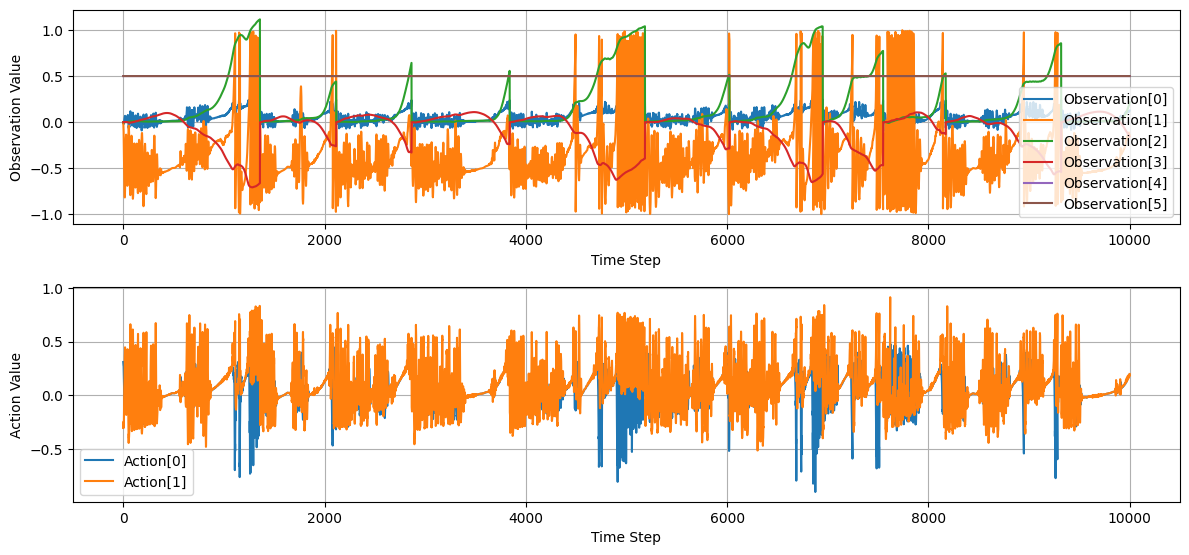

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from twsbr_env.envs import TwsbrEnv  # Import environment
from stable_baselines3 import SAC

# Muat kembali lingkungan dan model
env = gym.make("TwsbrEnv-v0", render_mode="human", action_type="continuous")
model = SAC.load("twsbr_sac_v2")

# Variabel penyimpanan data
obs_values = []
action_values = []

obs, info = env.reset()
terminated = False
truncated = False

def plot_results(obs_values, action_values):
    plt.figure(figsize=(12, 8))
    
    # Plot observasi
    for i in range(6):  # Karena ada 6 nilai observasi
        plt.subplot(3, 1, 1)
        plt.plot([obs[i] for obs in obs_values], label=f'Observation[{i}]')
    plt.xlabel("Time Step")
    plt.ylabel("Observation Value")                     
    plt.legend()
    plt.grid()
    
    # Plot aksi
    for i in range(2):  # Karena ada 2 nilai aksi
        plt.subplot(3, 1, 2)
        plt.plot([action[i] for action in action_values], label=f'Action[{i}]')
    plt.xlabel("Time Step")
    plt.ylabel("Action Value")
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()

for _ in range(10000):  # Jumlah langkah evaluasi
    action, _states = model.predict(obs, deterministic=True)
    obs_values.append(obs)
    action_values.append(action)
    obs, reward, terminated, truncated, info = env.step(action)
    
    if terminated:
        obs, info = env.reset()

# Tampilkan grafik
plot_results(obs_values, action_values)

# Menutup lingkungan
env.close()
